In [1]:
import os
import flwr as fl
import numpy as np
from enum import Enum
from tqdm import tqdm
import gc
import random
import time
import enum
import cv2
from zod.constants import Camera
from zod.data_classes.calibration import Calibration
from zod.data_classes.oxts import EgoMotion
from zod.utils.geometry import get_points_in_camera_fov, project_3d_to_2d_kannala, transform_points
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchsummary import summary
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

import plotly.express as px

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]

from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

# import the ZOD DevKit
from zod import ZodFrames
from zod import ZodSequences
from zod.visualization.oxts_on_image import visualize_oxts_on_image
import numpy as np
import cv2

# import default constants
import zod.constants as constants
from zod.constants import Camera, Lidar, Anonymization, AnnotationProject

NUM_OUTPUT = 66
OUTPUT_SIZE = 22
RUN_PRETRAINED = True
BATCH_SIZE = 64
DEVICE = torch.device('cpu')
IMG_SIZE = 224

def get_ground_truth(zod_frames, frame_id):
    # get frame
    zod_frame = zod_frames[frame_id]
    
    # extract oxts
    oxts = zod_frame.oxts
    
    # get timestamp
    key_timestamp = zod_frame.info.keyframe_time.timestamp()
    
    # get posses associated with frame timestamp
    current_pose = oxts.get_poses(key_timestamp)
    
    # transform poses
    all_poses = oxts.poses
    transformed_poses = np.linalg.pinv(current_pose) @ all_poses
    points = transformed_poses[:, :3, -1]
    points = points[points[:, 0] > 0]    
    
    # get equally distributed points 
    nr_points = points.shape[0]# // 2
    points = np.array([points[i] for i in range(0,nr_points,nr_points//OUTPUT_SIZE)][:OUTPUT_SIZE])
    return flatten_ground_truth(points), points
   
def transform_to_image_xy(zod_frames, frame_id, preds=None):
    """Visualize oxts track on image plane."""
    camera=Camera.FRONT
    zod_frame = zod_frames[frame_id]
    image = zod_frame.get_image(Anonymization.DNAT)
    calibs = zod_frame.calibration
    points, original = get_ground_truth(zod_frames, frame_id)
    points = reshape_ground_truth(points)
    
    # transform point to camera coordinate system
    T_inv = np.linalg.pinv(calibs.get_extrinsics(camera).transform)
    camerapoints = transform_points(points[:, :3], T_inv)
    #print(f"Number of points: {points.shape[0]}")

    # filter points that are not in the camera field of view
    points_in_fov = get_points_in_camera_fov(calibs.cameras[camera].field_of_view, camerapoints)
    #print(f"Number of points in fov: {len(points_in_fov)}")

    # project points to image plane
    xy_array = project_3d_to_2d_kannala(
        points_in_fov,
        calibs.cameras[camera].intrinsics[..., :3],
        calibs.cameras[camera].distortion,
    )
    return xy_array

def transform(zod_frames, frame_id, preds):
    """Visualize oxts track on image plane."""
    camera=Camera.FRONT
    zod_frame = zod_frames[frame_id]
    image = zod_frame.get_image(Anonymization.DNAT)
    calibs = zod_frame.calibration
    points, original = get_ground_truth(zod_frames, frame_id)
    points = reshape_ground_truth(points)
    
    # transform point to camera coordinate system
    T_inv = np.linalg.pinv(calibs.get_extrinsics(camera).transform)
    camerapoints = transform_points(points[:, :3], T_inv)
    #print(f"Number of points: {points.shape[0]}")

    # filter points that are not in the camera field of view
    points_in_fov = get_points_in_camera_fov(calibs.cameras[camera].field_of_view, camerapoints)
    #print(f"Number of points in fov: {len(points_in_fov)}")
    
    preds = reshape_ground_truth(preds)
    #print(f"Number of pred points on image: {preds.shape[0]}")
    predpoints = transform_points(preds[:, :3], T_inv)
    predpoints_in_fov = get_points_in_camera_fov(calibs.cameras[camera].field_of_view, predpoints)
    xy_array_preds = project_3d_to_2d_kannala(
        predpoints_in_fov,
        calibs.cameras[camera].intrinsics[..., :3],
        calibs.cameras[camera].distortion,
    )
    preds = []
    for i in range(xy_array_preds.shape[0]):
        x, y = int(xy_array_preds[i, 0]), int(xy_array_preds[i, 1])
        preds.append([x,y])
    return preds
 
def visualize_HP_on_image(zod_frames, frame_id, preds=None):
    """Visualize oxts track on image plane."""
    camera=Camera.FRONT
    zod_frame = zod_frames[frame_id]
    image = zod_frame.get_image(Anonymization.DNAT)
    calibs = zod_frame.calibration
    points, original = get_ground_truth(zod_frames, frame_id)
    points = reshape_ground_truth(points)
    
    
    # transform point to camera coordinate system
    T_inv = np.linalg.pinv(calibs.get_extrinsics(camera).transform)
    camerapoints = transform_points(points[:, :3], T_inv)
    print(f"Number of points: {points.shape[0]}")

    # filter points that are not in the camera field of view
    points_in_fov = get_points_in_camera_fov(calibs.cameras[camera].field_of_view, camerapoints)
    preds_in_fov = get_points_in_camera_fov(calibs.cameras[camera].field_of_view, preds)
    print(f"Number of points in fov: {len(points_in_fov)}")

    # project points to image plane
    xy_array = project_3d_to_2d_kannala(
        points_in_fov,
        calibs.cameras[camera].intrinsics[..., :3],
        calibs.cameras[camera].distortion,
    )
    
    pred_xy_array = project_3d_to_2d_kannala(
        preds_in_fov,
        calibs.cameras[camera].intrinsics[..., :3],
        calibs.cameras[camera].distortion,
    )
    
    ground_truth_color = (19, 80, 41)
    preds_color = (161, 65, 137)
    
    """Draw a line in image."""
    def draw_line(image, line, color):
        return cv2.polylines(image.copy(), [np.round(line).astype(np.int32)], isClosed=False, color=color, thickness=4)    
    
    points = []
    for i in range(xy_array.shape[0]):
        x, y = int(xy_array[i, 0]), int(xy_array[i, 1])
        cv2.circle(image, (x,y), 10, ground_truth_color, -1)
        points.append([x,y])
        
    points = []
    for i in range(pred_xy_array.shape[0]):
        x, y = int(pred_xy_array[i, 0]), int(pred_xy_array[i, 1])
        cv2.circle(image, (x,y), 5, preds_color, 2)
        points.append([x,y])
        
    image = draw_line(image, points[:len(points)//2], preds_color)
    image = draw_line(image, points[len(points)//2:], preds_color)
       
    plt.clf()
    plt.axis("off")
    #plt.imsave(f'inference_{frame_id}.png', image)
    plt.imshow(image)
    return image


def viz_bound(zod_frames, frame_id, image, preds=None):
    """Visualize oxts track on image plane."""
    camera=Camera.FRONT
    zod_frame = zod_frames[frame_id]
    calibs = zod_frame.calibration
    

    # filter points that are not in the camera field of view
    preds_in_fov = get_points_in_camera_fov(calibs.cameras[camera].field_of_view, preds)
    
    pred_xy_array = project_3d_to_2d_kannala(
        preds_in_fov,
        calibs.cameras[camera].intrinsics[..., :3],
        calibs.cameras[camera].distortion,
    )
    
    preds_color = (161, 65, 137)
    
    """Draw a line in image."""
    def draw_line(image, line, color):
        return cv2.polylines(image.copy(), [np.round(line).astype(np.int32)], isClosed=False, color=color, thickness=4)    

    points = []
    for i in range(pred_xy_array.shape[0]):
        x, y = int(pred_xy_array[i, 0]), int(pred_xy_array[i, 1])
        cv2.circle(image, (x,y), 5, preds_color, 2)
        points.append([x,y])
        
    image = draw_line(image, points[:len(points)//2], preds_color)
    image = draw_line(image, points[len(points)//2:], preds_color)
        
    plt.clf()
    plt.axis("off")
    #plt.imsave(f'inference_{frame_id}.png', image)
    plt.imshow(image)
    return image

def flatten_ground_truth(label):
    return label.flatten()

def reshape_ground_truth(label, output_size=OUTPUT_SIZE):
    return label.reshape((output_size,3))

class PTNet(nn.Module):
    def __init__(self) -> None:
        super(PTNet, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.is_pretrained = True

        """freeze parameters and replace head"""
        for param in self.model.parameters():
            param.requires_grad = False
        self.change_head_net()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return np.squeeze(self.model(x))

    def model_parameters(self):
        return self.get_head().parameters()

    def change_head_fc(self):
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, NUM_OUTPUT)

    def change_head_net(self):
        num_ftrs = self.model.fc.in_features
        head_net = nn.Sequential(
            nn.Linear(num_ftrs, 100, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(100, NUM_OUTPUT, bias=True),
        )
        self.model.fc = head_net

    def get_head(self):
        return self.model.fc
    
def net_instance(name):
    net = PTNet().to(DEVICE) if RUN_PRETRAINED else Net().to(DEVICE)
    #print(f"🌻 Created new model - {name} 🌻")
    return net

def get_transformed_image(zod_frames, frame_id):
    frame = zod_frames[frame_id]
    image = frame.get_image(Anonymization.DNAT)
    image = image.astype('float32')
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((IMG_SIZE, IMG_SIZE))])
    return torch.unsqueeze(transform(image), dim=0)

def load_model(name):
    #print(f"🛅 Loaded the model of client {name} from the disk. 🛅")
    net = net_instance(f"{name}")
    net.load_state_dict(torch.load(name))
    return net

def predict(model_path, zod_frames, frame_id):
    image = get_transformed_image(zod_frames, frame_id)
    model = load_model(model_path)
    outputs = model(image)
    preds = outputs.cpu().detach().numpy()
    return preds

In [2]:
dataset_root = "/mnt/ZOD"
version = "full"  # "mini" or "full"

zod_frames = ZodFrames(dataset_root=dataset_root, version=version)
training_frames_all = zod_frames.get_split(constants.TRAIN)
validation_frames_all = zod_frames.get_split(constants.VAL)

training_frames = training_frames_all[:len(training_frames_all)]
validation_frames = validation_frames_all[:len(validation_frames_all)]

print('training_frames length:', len(training_frames))
print('validation_frames length:', len(validation_frames))

Loading train frames:   0%|          | 0/89976 [00:00<?, ?it/s]

Loading val frames:   0%|          | 0/10024 [00:00<?, ?it/s]

training_frames length: 89976
validation_frames length: 10024


In [13]:
import plotly.graph_objects as go
#016019
frame_id = "019661" #training_frames_all[5]

flattened, original = get_ground_truth(zod_frames, frame_id)
points = reshape_ground_truth(flattened)

camera=Camera.FRONT
zod_frame = zod_frames[frame_id]
calibs = zod_frame.calibration

T_inv = np.linalg.pinv(calibs.get_extrinsics(camera).transform)
camerapoints = transform_points(points[:, :3], T_inv)

points = camerapoints

px.scatter_3d(x=points[:,0], y=points[:,1], z=points[:,2], title="Original", range_x=[-40,40], range_y=[-40,40], range_z=[-10,80])

In [14]:
print(camerapoints.shape)
camerapoints

(22, 3)


array([[ 1.66101422e-02,  1.13252201e+00, -1.99922952e+00],
       [ 1.46675844e-02,  1.12602704e+00, -1.99766629e+00],
       [ 9.30031808e-03,  1.13640072e+00, -1.82717329e+00],
       [ 8.78853047e-03,  1.13568796e+00, -1.82986371e+00],
       [ 1.87749881e-02,  1.17089648e+00, -1.84629668e+00],
       [-2.13667075e-03,  1.14349605e+00, -1.84103306e+00],
       [ 1.74755064e-02,  1.16528323e+00, -1.84616130e+00],
       [ 5.01979703e-02,  1.23139549e+00, -1.49107751e+00],
       [-8.51657784e-02,  1.19068030e+00,  3.73512192e+00],
       [-8.90325091e-01,  1.01957526e+00,  1.34311904e+01],
       [-4.99041269e-01,  9.36093085e-01,  2.27353834e+01],
       [ 5.78814817e+00,  1.09039010e+00,  2.88411448e+01],
       [ 1.66335132e+01,  1.32524705e+00,  3.10426835e+01],
       [ 3.03251935e+01,  1.63860811e+00,  3.35845624e+01],
       [ 4.50218838e+01,  1.87088209e+00,  3.64942444e+01],
       [ 5.91957442e+01,  1.96344690e+00,  3.99690821e+01],
       [ 7.29029859e+01,  1.94140520e+00

In [16]:
px.scatter(x=points[:,0], y=points[:,1], title="Original", range_x=[-40,40], range_y=[-40,40])

Number of points: 22
Number of points in fov: 9


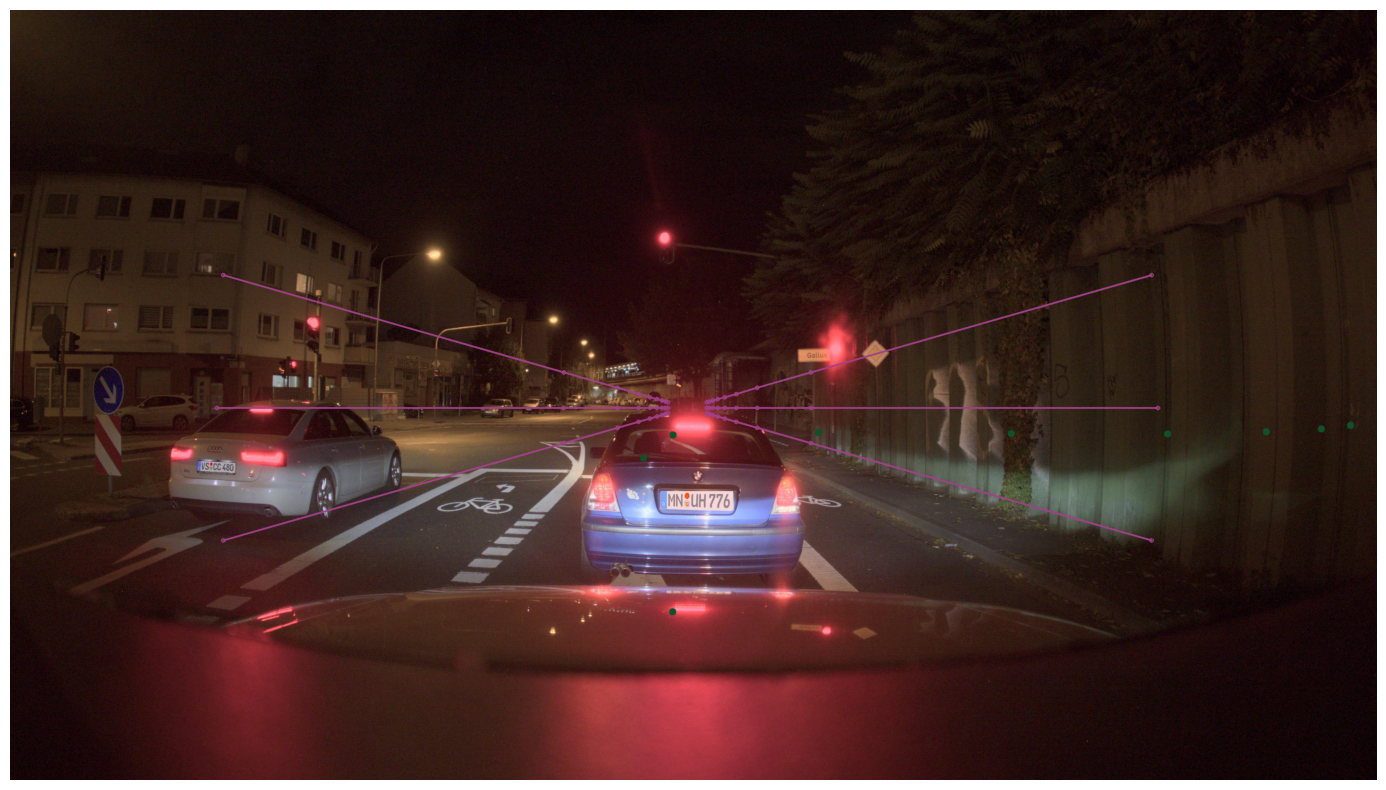

In [6]:
x_threshold = 7

boundry_points = np.zeros_like(camerapoints)
samples = len(boundry_points)
boundry_points[:samples//2, 0] = x_threshold
boundry_points[samples//2:, 0] = -x_threshold

boundry_points[:samples//2, 2] = [*range(-50, 320, 320//(samples//2))][:samples//2]
boundry_points[samples//2:, 2] = [*range(-50, 320, 320//(samples//2))][:samples//2]

px.scatter(x=boundry_points[:,0], y=boundry_points[:,1], title="Original", range_x=[-40,40], range_y=[-40,40])

img = visualize_HP_on_image(zod_frames, frame_id, boundry_points)
boundry_points[:, 1] = -2
img = viz_bound(zod_frames, frame_id, img, boundry_points)
boundry_points[:, 1] = 2
img = viz_bound(zod_frames, frame_id, img, boundry_points)


# Find frame ids where we turn

In [6]:
import ray
from zod import ZodFrames
from zod import constants 


def get_points(zod_frames, frame_id):
    # get frame
    zod_frame = zod_frames[frame_id]
    
    # extract oxts
    oxts = zod_frame.oxts
    
    # get timestamp
    key_timestamp = zod_frame.info.keyframe_time.timestamp()
    
    # get posses associated with frame timestamp
    current_pose = oxts.get_poses(key_timestamp)
    
    # transform poses
    all_poses = oxts.poses
    transformed_poses = np.linalg.pinv(current_pose) @ all_poses
    points = transformed_poses[:, :3, -1]
    points = points[points[:, 0] > 0]    
    
    # get equally distributed points 
    nr_points = points.shape[0] // 2
    points = np.array([points[i] for i in range(0,nr_points,nr_points//OUTPUT_SIZE)][:OUTPUT_SIZE])
    points = reshape_ground_truth(flatten_ground_truth(points))
    
    camera=Camera.FRONT
    calibs = zod_frame.calibration
    
    T_inv = np.linalg.pinv(calibs.get_extrinsics(camera).transform)
    return transform_points(points[:, :3], T_inv)



dataset_root = "/mnt/ZOD"
version = "full"  # "mini" or "full"
zod_frames = ZodFrames(dataset_root=dataset_root, version=version)
training_frames_all = zod_frames.get_split(constants.TRAIN)



n_sets = 20
set_length = len(training_frames_all)//20

chunks = [training_frames_all[i:i + set_length] for i in range(0, len(training_frames_all), set_length)]


Loading train frames:   0%|          | 0/89976 [00:00<?, ?it/s]

Loading val frames:   0%|          | 0/10024 [00:00<?, ?it/s]

In [7]:
threshold = 7
@ray.remote(num_cpus=3)
def categorise(zod_frames, set_of_ids):
    turns_right = []
    turns_left = []
    straights = []
    
    quarter = len(set_of_ids)//4

    for i, id in enumerate(set_of_ids):
        try:
            camerapoints = get_points(zod_frames, id)
            if any(camerapoints[:,0] > threshold):
                turns_right.append(id)
            elif any(camerapoints[:,0] < -threshold):
                turns_left.append(id)
            else:
                straights.append(id)
        except:
            pass
        if i % quarter == 0:
            print(f"{i/quarter*25}% done")
    return turns_left, turns_right, straights


results = ray.get([categorise.remote(zod_frames, chunk) for chunk in chunks])


2023-03-21 14:44:37,999	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(categorise pid=1885948) 0.0% done
(categorise pid=1885948) 25.0% done
(categorise pid=1885957) 0.0% done
(categorise pid=1885948) 50.0% done
(categorise pid=1885957) 25.0% done
(categorise pid=1885931) 0.0% done
(categorise pid=1885948) 75.0% done
(categorise pid=1885957) 50.0% done
(categorise pid=1885931) 25.0% done
(categorise pid=1885954) 0.0% done
(categorise pid=1885948) 100.0% done
(categorise pid=1885957) 75.0% done
(categorise pid=1885931) 50.0% done
(categorise pid=1885954) 25.0% done
(categorise pid=1885949) 0.0% done
(categorise pid=1885957) 100.0% done
(categorise pid=1885931) 75.0% done
(categorise pid=1885954) 50.0% done
(categorise pid=1885948) 0.0% done
(categorise pid=1885949) 25.0% done
(categorise pid=1885931) 100.0% done
(categorise pid=1885954) 75.0% done
(categorise pid=1885948) 25.0% done
(categorise pid=1885957) 0.0% done
(categorise pid=1885949) 50.0% done
(categorise pid=1885954) 100.0% done
(categorise pid=1885948) 50.0% done
(categorise pid=1885957) 25.0% 

In [13]:
all_left_turns = []
all_right_turns = []
all_straights = []

for result in results:
    all_left_turns += result[0]
    all_right_turns += result[1]
    all_straights += result[2]
    
lens = len(all_left_turns), len(all_right_turns), len(all_straights)
lens

(12484, 17303, 60161)

In [12]:
# save all turns to file on disk
with open("train_turns.txt", "w") as f:
    f.write("\n".join(all_left_turns + all_right_turns))
    
# save all LEFT turns to file on disk
with open("train_left_turns.txt", "w") as f:
    f.write("\n".join(all_left_turns))
    
# save all RIGHT turns to file on disk
with open("train_right_turns.txt", "w") as f:
    f.write("\n".join(all_right_turns))
    
# save all straights to file on disk
with open("train_straights.txt", "w") as f:
    f.write("\n".join(all_straights))

In [15]:
# create a balanced dataset
import random

smallest_set_size = min(lens)

left_turn_samples = random.sample(all_left_turns, smallest_set_size)
right_turn_samples = random.sample(all_right_turns, smallest_set_size)
straight_samples = random.sample(all_straights, smallest_set_size)

balanced_dataset = left_turn_samples + right_turn_samples + straight_samples
random.shuffle(balanced_dataset)

with open("balanced_train_ids.txt", "w") as f:
    f.write("\n".join(balanced_dataset))


# Validation set

In [16]:
import ray
from zod import ZodFrames
from zod import constants 


def get_points(zod_frames, frame_id):
    # get frame
    zod_frame = zod_frames[frame_id]
    
    # extract oxts
    oxts = zod_frame.oxts
    
    # get timestamp
    key_timestamp = zod_frame.info.keyframe_time.timestamp()
    
    # get posses associated with frame timestamp
    current_pose = oxts.get_poses(key_timestamp)
    
    # transform poses
    all_poses = oxts.poses
    transformed_poses = np.linalg.pinv(current_pose) @ all_poses
    points = transformed_poses[:, :3, -1]
    points = points[points[:, 0] > 0]    
    
    # get equally distributed points 
    nr_points = points.shape[0] // 2
    points = np.array([points[i] for i in range(0,nr_points,nr_points//OUTPUT_SIZE)][:OUTPUT_SIZE])
    points = reshape_ground_truth(flatten_ground_truth(points))
    
    camera=Camera.FRONT
    calibs = zod_frame.calibration
    
    T_inv = np.linalg.pinv(calibs.get_extrinsics(camera).transform)
    return transform_points(points[:, :3], T_inv)



dataset_root = "/mnt/ZOD"
version = "full"  # "mini" or "full"
zod_frames = ZodFrames(dataset_root=dataset_root, version=version)
validation_frames_all = zod_frames.get_split(constants.VAL)



n_sets = 20
set_length = len(validation_frames_all)//20

chunks = [validation_frames_all[i:i + set_length] for i in range(0, len(validation_frames_all), set_length)]



@ray.remote(num_cpus=5)
def categorise(zod_frames, set_of_ids):
    turns_right = []
    turns_left = []
    straights = []
    
    quarter = len(set_of_ids)//4

    for i, id in enumerate(set_of_ids):
        try:
            camerapoints = get_points(zod_frames, id)
            if any(camerapoints[:,0] > threshold):
                turns_right.append(id)
            elif any(camerapoints[:,0] < -threshold):
                turns_left.append(id)
            else:
                straights.append(id)
        except:
            pass
        if i % quarter == 0:
            print(f"{i/quarter*25}% done")
    return turns_left, turns_right, straights


results = ray.get([categorise.remote(zod_frames, chunk) for chunk in chunks])


Loading train frames:   0%|          | 0/89976 [00:00<?, ?it/s]

Loading val frames:   0%|          | 0/10024 [00:00<?, ?it/s]

(categorise pid=1885949) 0.0% done
(categorise pid=1885949) 25.0% done
(categorise pid=1885949) 50.0% done
(categorise pid=1885949) 75.0% done
(categorise pid=1885949) 100.0% done
(categorise pid=1885954) 0.0% done
(categorise pid=1885954) 25.0% done
(categorise pid=1885954) 50.0% done
(categorise pid=1885954) 75.0% done
(categorise pid=1885954) 100.0% done
(categorise pid=1885949) 0.0% done
(categorise pid=1885949) 25.0% done
(categorise pid=1885949) 50.0% done
(categorise pid=1885949) 75.0% done
(categorise pid=1885949) 100.0% done
(categorise pid=1885954) 0.0% done
(categorise pid=1885954) 25.0% done
(categorise pid=1885954) 50.0% done
(categorise pid=1885954) 75.0% done
(categorise pid=1885954) 100.0% done
(categorise pid=1885949) 0.0% done
(categorise pid=1885949) 25.0% done
(categorise pid=1885949) 50.0% done
(categorise pid=1885949) 75.0% done
(categorise pid=1885949) 100.0% done
(categorise pid=1885954) 0.0% done
(categorise pid=1885954) 25.0% done
(categorise pid=1885954) 50.0

In [17]:
all_left_turns = []
all_right_turns = []
all_straights = []

for result in results:
    all_left_turns += result[0]
    all_right_turns += result[1]
    all_straights += result[2]
    
lens = len(all_left_turns), len(all_right_turns), len(all_straights)
lens

(1246, 2111, 6667)

In [18]:
# save all turns to file on disk
with open("val_turns.txt", "w") as f:
    f.write("\n".join(all_left_turns + all_right_turns))
    
# save all LEFT turns to file on disk
with open("val_left_turns.txt", "w") as f:
    f.write("\n".join(all_left_turns))
    
# save all RIGHT turns to file on disk
with open("val_right_turns.txt", "w") as f:
    f.write("\n".join(all_right_turns))
    
# save all straights to file on disk
with open("val_straights.txt", "w") as f:
    f.write("\n".join(all_straights))

In [19]:
# create a balanced dataset
import random

smallest_set_size = min(lens)

left_turn_samples = random.sample(all_left_turns, smallest_set_size)
right_turn_samples = random.sample(all_right_turns, smallest_set_size)
straight_samples = random.sample(all_straights, smallest_set_size)

balanced_dataset = left_turn_samples + right_turn_samples + straight_samples
random.shuffle(balanced_dataset)

with open("balanced_val_ids.txt", "w") as f:
    f.write("\n".join(balanced_dataset))


In [22]:
# create a balanced dataset in one file
with open("balanced_train_ids.txt", "r") as f:
    train_ids = f.read()
    
with open("balanced_val_ids.txt", "r") as f:
    val_ids = f.read()
    
with open("balanced_frames.txt", "w") as f:
    f.write("%TRAIN_BALANCED\n")
    f.write(train_ids)
    f.write("%VAL_BALANCED\n")
    f.write(val_ids)

(raylet) [2023-03-21 15:38:37,921 E 1885723 1885723] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 7e58a52f44b6c7b37356ae875d5e96bbdd36adbed01b6eec63379ca4, IP: 172.25.17.195) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.25.17.195`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) [2023-03-21 15:45:37,928 E 1885723 1885723] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) 

In [6]:
corrupt_labels = set(['065644', '011950', '098939', '019180', '081417', '006820', '024706', '096708', '015361', '058768', '085665', '061939', '055269', '027010', '085884', '013722', '053300', '084894', '056046', '081670', '042235', '088568', '030137', '062424', '079558', '058543', '019863', '005063', '091005', '052067', '058355', '073891', '010961', '081841', '059038', '075155', '056047', '055799', '060196', '026807', '097248', '083883', '093495', '033850', '055871', '011671', '068151', '059138', '096970', '057623', '095901', '094430', '060380', '060170', '053988', '042345', '066143', '095461', '088890', '056350', '099029', '056602', '081452', '060371', '059245', '089308', '056802', '056089', '074612', '054693', '094180', '041921', '087558', '085515', '037456', '008938', '059914', '055775', '053832', '058200', '057122', '020843', '082524', '057752', '098660', '049220', '053839', '055192', '074967', '061009', '086327', '003128', '087311', '095253', '055872', '070585', '061742', '053712', '092027', '095594', '007109', '089292', '075997', '016241', '062825', '061408', '086941', '094045', '056191', '076380', '054592', '051924', '055306', '019397', '078544', '097724', '085054', '083647'])
corrupt_images = set(['005350'])

# lets remove these from the final sets
with open("balanced_dataset/balanced_frames.txt", "r") as f:
    frames = f.read().splitlines()

with open("balanced_dataset/balanced_frames_clean.txt", "w") as f:
    for row in frames:
        if row not in corrupt_labels and row not in corrupt_images:
            f.write(f"{row}\n")